In [21]:
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

MC_DATA_FOLDER = "../results/MC_data_1e7"

# phantom radii to plot 
Rs = [5.0, 10.0, 15.0]

# detector ring radius (cm)
R_DET_CM = 15.0

# FINITE axial FOV / ring length (cm)
RING_LENGTH_CM = 30.0          
Z_MAX_DET_CM = 0.5 * RING_LENGTH_CM

# histogram settings
BIN_WIDTH_R = 0.05  # cm for r_perp
BIN_WIDTH_Z = 0.05  # cm for |z*|  

# plot ranges
RPERP_MAXS = [7.0, 7.0, 7.0]   # per-panel x-lims for r_perp
ZABS_MAXS  = [7.0, 7.0, 7.0]   # per-panel x-lims for |z*|

BINS_R = int(max(RPERP_MAXS) / BIN_WIDTH_R) + 1
BINS_Z = int(max(ZABS_MAXS)  / BIN_WIDTH_Z) + 1

print("BINS_R:", BINS_R, "BIN_WIDTH_R:", BIN_WIDTH_R)
print("BINS_Z:", BINS_Z, "BIN_WIDTH_Z:", BIN_WIDTH_Z)

YLIMS_R = [(0, 70000), (0, 20000), (0, 4000)]  
YLIMS_Z = [(0, 150000), (0, 50000), (0, 10000)]

energy_thresholds = np.array([400,410,420,430,440,450,460,470,480,490,500,510], float)

# figure sizing
COLUMNWIDTH_PT = 242.5389
INCH_PER_PT = 1 / 72.27
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT
FIG_H = FIG_W * 2.5

FONTSIZE = 10
TICKLABELSIZE = 8

CMAP = plt.cm.inferno
CMAP_MIN, CMAP_MAX = 0.20, 0.85
colors = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, len(energy_thresholds)))

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": FONTSIZE,
    "axes.labelsize": TICKLABELSIZE,
    "xtick.labelsize": TICKLABELSIZE,
    "ytick.labelsize": TICKLABELSIZE,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.color": "white",
    "axes.axisbelow": True,
    "grid.alpha": 0.9,
    "grid.linewidth": 1.0,
    "axes.facecolor": "whitesmoke",
})


BINS_R: 141 BIN_WIDTH_R: 0.05
BINS_Z: 141 BIN_WIDTH_Z: 0.05


In [2]:
def intersect_cylinder_vec_finite(
    exit_x, exit_y, exit_z, nx, ny, nz,
    *, R_det_cm: float, z_max_cm: float, eps: float = 1e-12
):
    """Compute intersection of rays with finite cylinder.
    """
    exit_x = np.asarray(exit_x, float)
    exit_y = np.asarray(exit_y, float)
    exit_z = np.asarray(exit_z, float)
    nx = np.asarray(nx, float)
    ny = np.asarray(ny, float)
    nz = np.asarray(nz, float)

    a = nx*nx + ny*ny
    b = 2.0*(exit_x*nx + exit_y*ny)
    c = exit_x*exit_x + exit_y*exit_y - R_det_cm*R_det_cm

    px = np.full_like(exit_x, np.nan, dtype=float)
    py = np.full_like(exit_y, np.nan, dtype=float)
    pz = np.full_like(exit_z, np.nan, dtype=float)

    ok_dir = a > eps
    disc = b*b - 4.0*a*c
    ok = ok_dir & (disc >= 0.0)
    if not np.any(ok):
        return px, py, pz

    sqrt_disc = np.sqrt(disc[ok])
    a_ok = a[ok]
    b_ok = b[ok]

    t1 = (-b_ok - sqrt_disc) / (2.0*a_ok)
    t2 = (-b_ok + sqrt_disc) / (2.0*a_ok)

    # candidate points for both roots
    idx_ok = np.flatnonzero(ok)

    t1_ok = t1
    t2_ok = t2

    # Compute z at both candidates
    z1 = exit_z[idx_ok] + t1_ok * nz[idx_ok]
    z2 = exit_z[idx_ok] + t2_ok * nz[idx_ok]

    valid1 = (t1_ok > eps) & (np.abs(z1) <= z_max_cm)
    valid2 = (t2_ok > eps) & (np.abs(z2) <= z_max_cm)

    # choose smallest positive valid t among candidates
    t_choice = np.where(valid1 & valid2, np.minimum(t1_ok, t2_ok),
                        np.where(valid1, t1_ok,
                                 np.where(valid2, t2_ok, np.nan)))

    keep = ~np.isnan(t_choice)
    if not np.any(keep):
        return px, py, pz

    idx = idx_ok[keep]
    t_use = t_choice[keep]

    px[idx] = exit_x[idx] + t_use * nx[idx]
    py[idx] = exit_y[idx] + t_use * ny[idx]
    pz[idx] = exit_z[idx] + t_use * nz[idx]
    return px, py, pz


In [3]:
def accumulate_hist_rperp_z_from_photon_file(
    feather_path: str,
    *,
    R_det_cm: float,
    z_max_det_cm: float,
    rperp_max: float,
    zabs_max: float,
    bins_r: int,
    bins_z: int,
    bin_width_r: float,
    bin_width_z: float,
    energy_thresholds: np.ndarray,
    counts_r_accum: np.ndarray,   # shape [nEth, bins_r]
    counts_z_accum: np.ndarray,   # shape [nEth, bins_z]
):
    """
    Acceptance:
      - photon_index in {1,2}
      - (optional) exited/detected if present
      - both photons intersect finite detector cylinder at fixed radius
      - at least one photon scattered (n_object_scatters > 0 in pair)
      - energy threshold: min(E1,E2) >= Eth
    """
    cols = [
        "annihilation_ID", "photon_index",
        "exit_x", "exit_y", "exit_z",
        "n_x", "n_y", "n_z",
        "n_object_scatters",
        "E_exit_keV",
    ]
    opt_cols = ["exited", "detected"]

    df = pd.read_feather(feather_path)
    keep = [c for c in cols if c in df.columns] + [c for c in opt_cols if c in df.columns]
    df = df[keep]

    if "exited" in df.columns:
        df = df[df["exited"].to_numpy(bool)]
    if "detected" in df.columns:
        df = df[df["detected"].to_numpy(bool)]
    df = df[df["photon_index"].isin([1, 2])]
    if len(df) == 0:
        return

    px, py, pz = intersect_cylinder_vec_finite(
        df["exit_x"].to_numpy(float),
        df["exit_y"].to_numpy(float),
        df["exit_z"].to_numpy(float),
        df["n_x"].to_numpy(float),
        df["n_y"].to_numpy(float),
        df["n_z"].to_numpy(float),
        R_det_cm=R_det_cm,
        z_max_cm=z_max_det_cm,
    )
    df["px"], df["py"], df["pz"] = px, py, pz
    df = df.dropna(subset=["px", "py", "pz"])
    if len(df) == 0:
        return

    # pair photons
    df = df.sort_values(["annihilation_ID", "photon_index"], kind="mergesort")
    counts = df["annihilation_ID"].value_counts(sort=False)
    good_ids = counts.index[counts.to_numpy() == 2]
    df = df[df["annihilation_ID"].isin(good_ids)]
    if len(df) == 0:
        return
    df = df.sort_values(["annihilation_ID", "photon_index"], kind="mergesort")

    P = df[["px", "py", "pz"]].to_numpy(float).reshape(-1, 2, 3)
    S = df[["n_object_scatters"]].to_numpy(int).reshape(-1, 2)
    E = df[["E_exit_keV"]].to_numpy(float).reshape(-1, 2)

    # require at least one scatter
    m_scatter = (S[:, 0] > 0) | (S[:, 1] > 0)
    if not np.any(m_scatter):
        return
    P = P[m_scatter]
    E = E[m_scatter]

    p1 = P[:, 0, :]
    p2 = P[:, 1, :]

    # closest approach point to origin
    v = p2 - p1
    vv = np.sum(v * v, axis=1)
    ok = vv > 1e-12
    if not np.any(ok):
        return

    p1 = p1[ok]
    p2 = p2[ok]
    E = E[ok]

    v = p2 - p1
    vv = np.sum(v * v, axis=1)
    s = -np.sum(p1 * v, axis=1) / vv
    closest = p1 + (s[:, None] * v)

    r_perp = np.sqrt(closest[:, 0]**2 + closest[:, 1]**2)
    z_abs  = np.abs(closest[:, 2])

    mr = np.isfinite(r_perp) & (r_perp >= 0.0) & (r_perp <= rperp_max)
    mz = np.isfinite(z_abs)  & (z_abs  >= 0.0) & (z_abs  <= zabs_max)
    m = mr & mz
    if not np.any(m):
        return

    r_perp = r_perp[m]
    z_abs  = z_abs[m]
    E = E[m]

    Emin_pair = np.minimum(E[:, 0], E[:, 1])

    for j, Eth in enumerate(energy_thresholds):
        mE = Emin_pair >= Eth
        if not np.any(mE):
            continue

        hr, _ = np.histogram(r_perp[mE], bins=bins_r, range=(0.0, rperp_max))
        hz, _ = np.histogram(z_abs[mE],  bins=bins_z, range=(0.0, zabs_max))
        counts_r_accum[j] += hr
        counts_z_accum[j] += hz


In [4]:
def compute_histograms_fixed_ring_for_R_rperp_z(
    R_obj: float,
    *,
    mc_folder: str,
    R_det_cm: float,
    z_max_det_cm: float,
    rperp_max: float,
    zabs_max: float,
    bins_r: int,
    bins_z: int,
    bin_width_r: float,
    bin_width_z: float,
    energy_thresholds: np.ndarray,
):
    phot_files = sorted(glob.glob(f"{mc_folder}/photons_*_R{int(R_obj)}.feather"))
    if not phot_files:
        raise FileNotFoundError(f"No photon files found for R={R_obj} in {mc_folder}")

    counts_r = np.zeros((len(energy_thresholds), bins_r), dtype=np.int64)
    counts_z = np.zeros((len(energy_thresholds), bins_z), dtype=np.int64)

    for k, f in enumerate(phot_files):
        accumulate_hist_rperp_z_from_photon_file(
            f,
            R_det_cm=R_det_cm,
            z_max_det_cm=z_max_det_cm,
            rperp_max=rperp_max,
            zabs_max=zabs_max,
            bins_r=bins_r,
            bins_z=bins_z,
            bin_width_r=bin_width_r,
            bin_width_z=bin_width_z,
            energy_thresholds=energy_thresholds,
            counts_r_accum=counts_r,
            counts_z_accum=counts_z,
        )
        if (k + 1) % 10 == 0 or (k + 1) == len(phot_files):
            print(f"R={R_obj}: processed {k+1}/{len(phot_files)} shards")

    return counts_r, counts_z   # [nEth,bins_r], [nEth,bins_z]


In [5]:
hist_r_by_R = {}
hist_z_by_R = {}

for R_obj, rmax, zmax in zip(Rs, RPERP_MAXS, ZABS_MAXS):
    Hr, Hz = compute_histograms_fixed_ring_for_R_rperp_z(
        R_obj,
        mc_folder=MC_DATA_FOLDER,
        R_det_cm=R_DET_CM,
        z_max_det_cm=Z_MAX_DET_CM,
        rperp_max=rmax,
        zabs_max=zmax,
        bins_r=BINS_R,
        bins_z=BINS_Z,
        bin_width_r=BIN_WIDTH_R,
        bin_width_z=BIN_WIDTH_Z,
        energy_thresholds=energy_thresholds,
    )
    hist_r_by_R[R_obj] = Hr
    hist_z_by_R[R_obj] = Hz


R=5.0: processed 10/50 shards
R=5.0: processed 20/50 shards
R=5.0: processed 30/50 shards
R=5.0: processed 40/50 shards
R=5.0: processed 50/50 shards
R=10.0: processed 10/50 shards
R=10.0: processed 20/50 shards
R=10.0: processed 30/50 shards
R=10.0: processed 40/50 shards
R=10.0: processed 50/50 shards
R=15.0: processed 10/50 shards
R=15.0: processed 20/50 shards
R=15.0: processed 30/50 shards
R=15.0: processed 40/50 shards
R=15.0: processed 50/50 shards


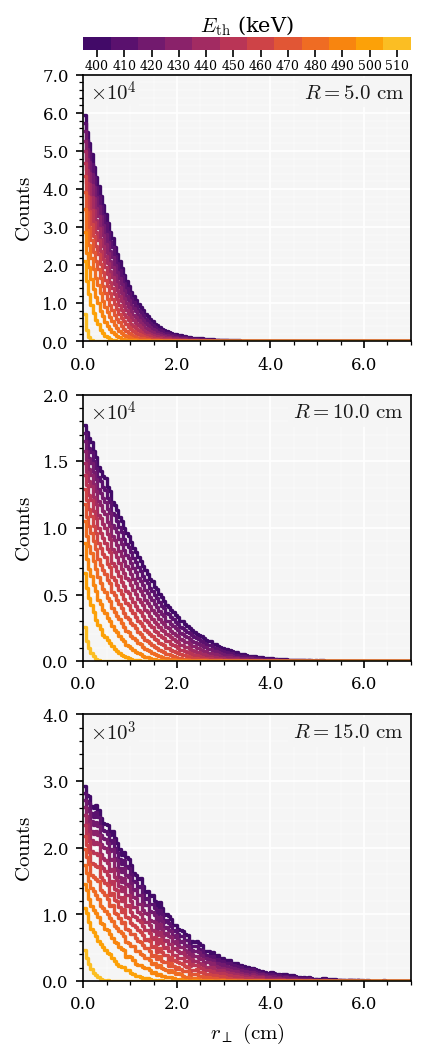

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(FIG_W, FIG_H), sharex=False)
fig.subplots_adjust(left=0.15, right=0.80, top=0.8, bottom=0.08, hspace=0.20)

centers_r = (np.arange(BINS_R) + 0.5) * BIN_WIDTH_R

for i, (R_obj, rmax) in enumerate(zip(Rs, RPERP_MAXS)):
    ax = axes[i]
    counts_accum = hist_r_by_R[R_obj]  # [nEth, bins_r]

    for (Eth, col, counts) in zip(energy_thresholds, colors, counts_accum):
        ax.step(centers_r, counts, where="mid", linewidth=1.6, color=col)

    ax.set_ylim(*YLIMS_R[i])
    ax.set_ylabel(r"$\mathrm{Counts}$", fontdict={"size": FONTSIZE})

    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig.canvas.draw()
    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}")
    )

    ax.text(
        0.02, 0.98, rf"$\times 10^{{{oom}}}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0),
        zorder=10,
    )

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.tick_params(labelbottom=True)
    if i == 2:
        ax.set_xlabel(r"$r_{\perp}~\mathrm{(cm)}$", fontdict={"size": FONTSIZE})

    ax.text(
        0.98, 0.97,
        rf"$R = {R_obj:.1f}~\mathrm{{cm}}$",
        transform=ax.transAxes,
        va="top", ha="right",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    ax.set_xlim(0.0, rmax)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(colors), norm=norm)
sm.set_array([])

top_pos = axes[0].get_position()
cbar_h = 0.01
gap = 0.02
cax = fig.add_axes([top_pos.x0, top_pos.y1 + gap, top_pos.width, cbar_h])

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=np.arange(N) + 0.5, drawedges=False)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}$ (keV)", fontsize=FONTSIZE, labelpad=2.5)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=6, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)

plt.show()


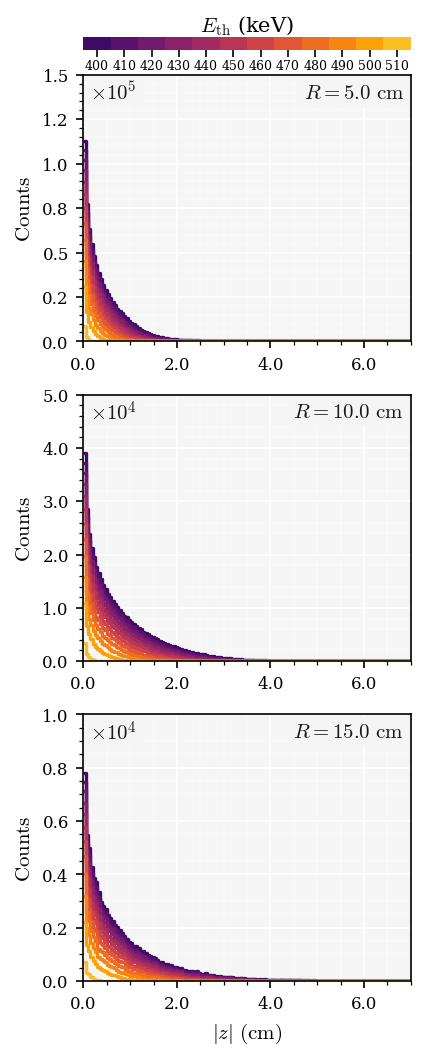

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(FIG_W, FIG_H), sharex=False)
fig.subplots_adjust(left=0.15, right=0.80, top=0.8, bottom=0.08, hspace=0.20)

centers_z = (np.arange(BINS_Z) + 0.5) * BIN_WIDTH_Z

for i, (R_obj, zmax) in enumerate(zip(Rs, ZABS_MAXS)):
    ax = axes[i]
    counts_accum = hist_z_by_R[R_obj]  # [nEth, bins_z]

    for (Eth, col, counts) in zip(energy_thresholds, colors, counts_accum):
        ax.step(centers_z, counts, where="mid", linewidth=1.6, color=col)

    ax.set_ylim(*YLIMS_Z[i])
    ax.set_ylabel(r"$\mathrm{Counts}$", fontdict={"size": FONTSIZE})

    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig.canvas.draw()
    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}")
    )

    ax.text(
        0.02, 0.98, rf"$\times 10^{{{oom}}}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0),
        zorder=10,
    )

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.tick_params(labelbottom=True)
    if i == 2:
        ax.set_xlabel(r"$|z|~\mathrm{(cm)}$", fontdict={"size": FONTSIZE})

    ax.text(
        0.98, 0.97,
        rf"$R = {R_obj:.1f}~\mathrm{{cm}}$",
        transform=ax.transAxes,
        va="top", ha="right",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    ax.set_xlim(0.0, zmax)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

# colorbar
N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(colors), norm=norm)
sm.set_array([])

top_pos = axes[0].get_position()
cbar_h = 0.01
gap = 0.02
cax = fig.add_axes([top_pos.x0, top_pos.y1 + gap, top_pos.width, cbar_h])

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=np.arange(N) + 0.5, drawedges=False)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}$ (keV)", fontsize=FONTSIZE, labelpad=2.5)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=6, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)

plt.show()
